### Librerias

In [1]:
# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, 
    precision_score, recall_score, balanced_accuracy_score, 
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from catboost import CatBoostClassifier, Pool, cv, CatBoostError

# Interpretabilidad
import shap

# Guardar modelo
import joblib


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Bases

In [2]:
# Base inicial
df_final = pd.read_csv("data/df_final.csv")
df_final['DescRF_Identificacion'] = df_final['DescRF_Identificacion'].astype(str).str.strip()

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10316\2983733256.py:2: DtypeWarning: Columns (18,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv("C:/Users/Administrator/Downloads/df_final.csv")


### Selección de variables modelo

In [3]:
variables_utiles = [
    'DescRF_Tipo_estado_alumno', # categorica
    'DescRF_Modalidad', # categorica
    'DescRF_Semestre_SINU', # numerica
    'DescRF_ciclo', # categorica
    'DescRF_SEMESTRE_MEN', #numerica
    'DescRF_Genero', # categorica
    'DescRF_Unidad', # categorica
    'DescRF_Jornada', # categorica
    'DescRF_Tipo_Inscripcion', # categorica
    'DescRF_Sede', # categorica
    'DescRF_Regional', # categorica
    'DescRF_Programa', # categorica
    'DescRF_Fondo', # categorica
    'DescRF_Producto', # categorica
    'DescRF_Fuente', # categorica
    'DescRF_REGLA_ACA', # numerica
    'DescRF_REGLA_INGLES', # numerica
    'DescRF_perdida_academica', # numerica
    'DescRF_tiene_grado', # numerica
    'DescRF_graduado', # numerica
    'DescRF_cod_ciclo', # numerica
    'DescRF_Tipo_Alumno', # categorica
    'DescRF_Nuevo', # categorica
    'DescRF_Valor_Liquidado', # numerica
    'DescRF_Creditos_Orden', # numerica
    'DescAM_MATERIAS_INSCRITAS', # numerica
    'DescAM_MATERIAS_APROBADAS', # numerica
    'DescAM_Porcentaje_aprobacion', # numerica
    'EEpromedio', # numerica
    'EE_UNIDADNEGOCIO', # categorica
    'EE_DEPARTAMENTO_REGIONAL', # categorica
    'EE_OTRA_DISCAPACIDAD', # categorica
    'EE_ESTRATO_ACTUALIZADO', # numerica
    'Grupo_Edad', # numerica
    'Trabaja', # categorica
    'Deserto' # binaria formada variable respuesta
]
df_modelo = df_final[variables_utiles].copy()


### Separación de los datos

In [4]:
df_temp = df_modelo.copy()

variables_categoricas = df_temp.select_dtypes(include=['object', 'category']).columns

# Codificar variables 
le = LabelEncoder()
for col in variables_categoricas:
    df_temp[col] = le.fit_transform(df_temp[col].astype(str))

X = df_temp.drop('Deserto', axis=1)
y = df_temp['Deserto']

# División 70% entrenamiento, 20% validación y 10% prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1111, stratify=y_train_full, random_state=42)

print(f"Train: {len(X_train)} \nValidación: {len(X_val)} \nTest: {len(X_test)}")


Train: 143808 
Validación: 17974 
Test: 40446


#### CatBoost

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Mejores parámetros encontrados:
 {'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 1500, 'depth': 8, 'border_count': 128}


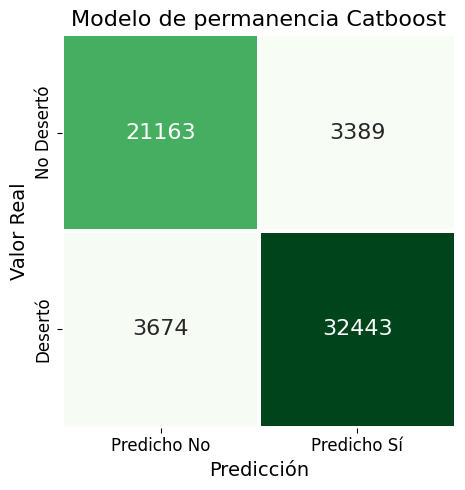

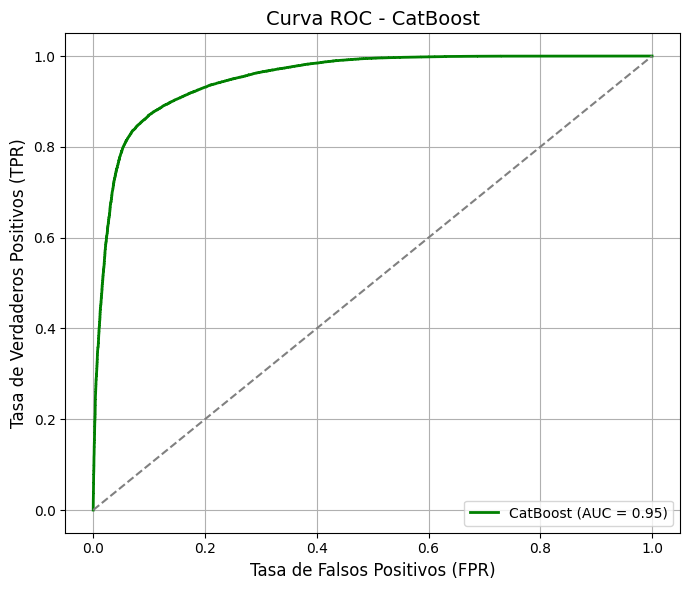

Reporte de clasificación:
              precision    recall  f1-score   support

  No Desertó     0.8521    0.8620    0.8570     24552
     Desertó     0.9054    0.8983    0.9018     36117

    accuracy                         0.8836     60669
   macro avg     0.8787    0.8801    0.8794     60669
weighted avg     0.8838    0.8836    0.8837     60669


 Métricas en conjunto de prueba (Test):

Accuracy: 0.8836
F1-score: 0.9018
ROC-AUC: 0.9514
Precision: 0.9054
Recall (Sensibilidad): 0.8983
Balanced Accuracy: 0.8801
Specificity: 0.862


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10316\2211221420.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=top_importances.values, y=top_importances.index, palette="Greens_r")


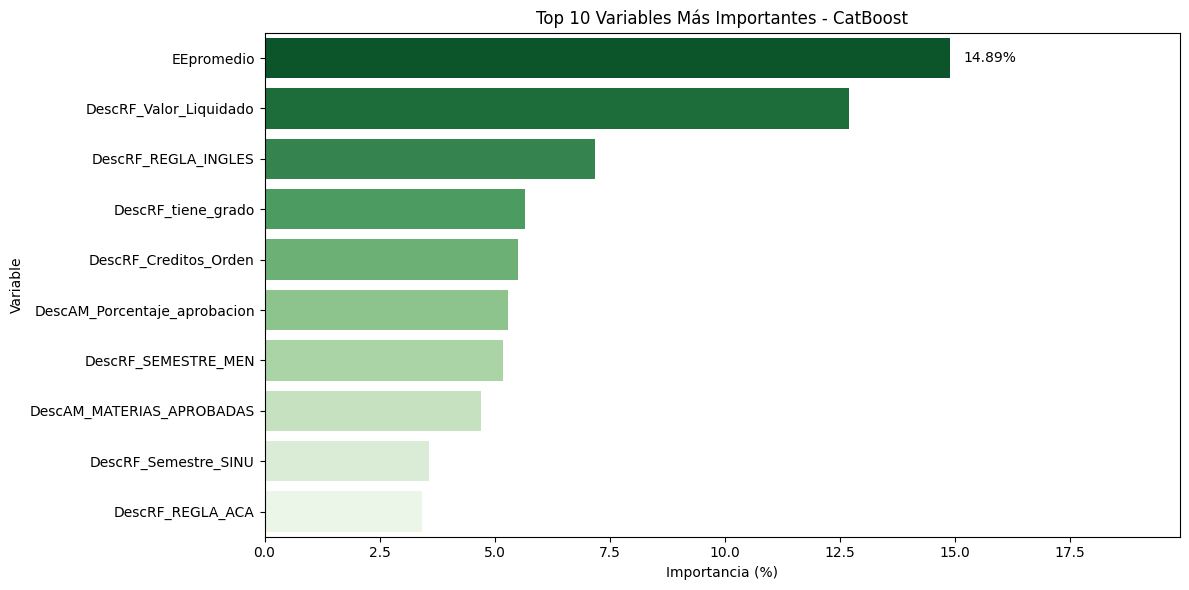

['modelo_catboost_desercion.pkl']

In [5]:
# División de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Modelo
catboost = CatBoostClassifier(verbose=0, random_state=42)

# HIiperparámetros
param_dist = {
    'iterations': [1500], # Total árboles
    'learning_rate': [0.01, 0.05, 0.1], # Ajuste modelo en cada iteracion
    'depth': [4, 6, 8], # Profundidad máxima de cada árbol
    'l2_leaf_reg': [1, 3, 5, 7], # Regularización L2
    'border_count': [32, 64, 128] # Divisiones usadas al convertir varianles numéricas
}

search = RandomizedSearchCV(catboost, param_distributions=param_dist, 
                            n_iter=20, scoring='roc_auc', 
                            cv=2, verbose=1, random_state=42, n_jobs=-1)

search.fit(X_train, y_train)

modelo_cat = search.best_estimator_
print("Mejores parámetros encontrados:\n", search.best_params_)

# Predicciones
y_pred = modelo_cat.predict(X_test)
y_proba = modelo_cat.predict_proba(X_test)[:,1]


# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=['No Desertó', 'Desertó'], 
                     columns=['Predicho No', 'Predicho Sí'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greens', linewidths=1.5, linecolor='white',
            annot_kws={"size": 16}, cbar=False, square=True)

plt.title('Modelo de permanencia Catboost', fontsize=16)
plt.ylabel('Valor Real', fontsize=14)
plt.xlabel('Predicción', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'CatBoost (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curva ROC - CatBoost', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Desertó', 'Desertó'], digits = 4))

# Predicciones y probabilidades sobre el conjunto de prueba
y_pred_test = modelo_cat.predict(X_test)
y_proba_test = modelo_cat.predict_proba(X_test)[:, 1]

# Matriz de confusión para obtener la especificidad
cm_test = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm_test.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Métricas de evaluación en test
print("\n Métricas en conjunto de prueba (Test):\n")
print("Accuracy:", round(accuracy_score(y_test, y_pred_test), 4))
print("F1-score:", round(f1_score(y_test, y_pred_test), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_test), 4))
print("Precision:", round(precision_score(y_test, y_pred_test), 4))
print("Recall (Sensibilidad):", round(recall_score(y_test, y_pred_test), 4))
print("Balanced Accuracy:", round(balanced_accuracy_score(y_test, y_pred_test), 4))
print("Specificity:", round(specificity, 4))

# Importancia de variables 
importances = pd.Series(modelo_cat.feature_importances_, index=X.columns)
importances_pct = (importances / importances.sum() * 100).sort_values(ascending=False)

# Mostrar top 10
top_importances = importances_pct.head(10)

plt.figure(figsize=(12, 6))
bars = sns.barplot(x=top_importances.values, y=top_importances.index, palette="Greens_r")

# Agregar etiquetas
for bar in bars.containers[0]:
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}%', va='center', fontsize=10)

plt.title("Top 10 Variables Más Importantes - CatBoost")
plt.xlabel("Importancia (%)")
plt.ylabel("Variable")
plt.xlim(0, top_importances.values.max() + 5)
plt.tight_layout()
plt.show()

# Guardar modelo
joblib.dump(modelo_cat, 'modelo_catboost_desercion.pkl')


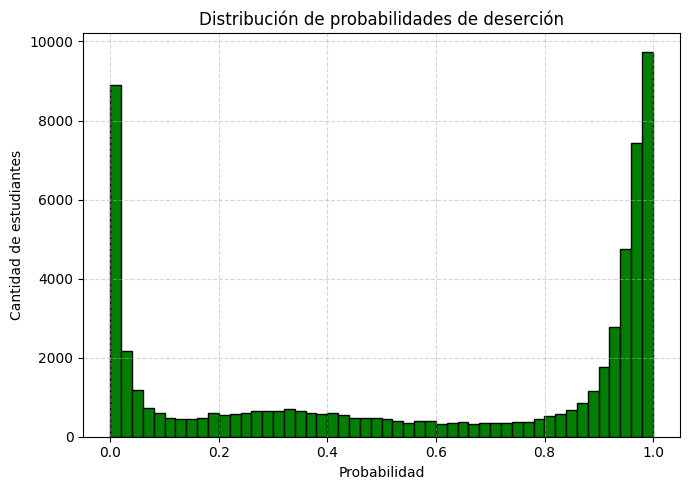

In [16]:
plt.figure(figsize=(7,5))
plt.hist(y_proba, bins=50, color="green", edgecolor="black")
plt.title("Distribución de probabilidades de deserción")
plt.xlabel("Probabilidad")
plt.ylabel("Cantidad de estudiantes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### SHAP

In [14]:
# Inicializar SHAP JS
shap.initjs()

# Explicador SHAP para modelo LightGBM
explainer_cat = shap.TreeExplainer(modelo_cat)
shap_values_cat = explainer_cat.shap_values(X_test)

# Convertir a DataFrame
shap_df = pd.DataFrame(shap_values_cat, columns=["SHAP_" + c for c in X.columns])
df_resultado = pd.concat([df_final[["DescRF_Identificacion"]], pd.Series(y_proba, name="ProbabilidadDesercion"), shap_df], axis=1)

# TOP 3 VARIABLES SHAP
def top_3_variables(shap_row, feature_names):
    top_idx = np.argsort(np.abs(shap_row))[-3:][::-1]
    return ", ".join([f"{feature_names[i]} ({shap_row[i]:.2f})" for i in top_idx])

df_resultado["TOP_3_VARIABLES"] = shap_df.apply(lambda row: top_3_variables(row.values, shap_df.columns), axis=1)

# Estudiantes con más riesgo
top_riesgo = df_resultado.sort_values(by="ProbabilidadDesercion", ascending=False).head(5)
print("\n🎯 TOP 5 ESTUDIANTES EN RIESGO")
print(top_riesgo[["DescRF_Identificacion", "ProbabilidadDesercion", "TOP_3_VARIABLES"]])


🎯 TOP 5 ESTUDIANTES EN RIESGO
       DescRF_Identificacion  ProbabilidadDesercion  \
59797             1018495233               0.999511   
38267             1010176626               0.999426   
14225             1001340668               0.999368   
53285             1015450115               0.999293   
58987             1018457006               0.999273   

                                         TOP_3_VARIABLES  
59797  SHAP_DescRF_Unidad (1.44), SHAP_EEpromedio (0....  
38267  SHAP_DescRF_Unidad (1.26), SHAP_EEpromedio (0....  
14225  SHAP_DescRF_Unidad (1.28), SHAP_EEpromedio (0....  
53285  SHAP_DescRF_Unidad (1.25), SHAP_EEpromedio (0....  
58987  SHAP_DescRF_Unidad (1.26), SHAP_EEpromedio (0....  
